# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

План работы:
    1. Определиться с признаками (вопрос с температурами).
    2. Построить модели
    3. Добиться нужного значения метрики МАЕ
    4. Сделать выводы
    5. Написать отчет

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Импортирую библиотеки**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Загружаю данные**

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv') 
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

***Данные об электродах***

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [6]:
print(data_arc[data_arc['Активная мощность'].isnull()].count())

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [7]:
data_arc.dropna()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [8]:
data_arc = data_arc.drop_duplicates().reset_index(drop=True)
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [9]:
data_arc['N'] = data_arc['Активная мощность'] + data_arc['Реактивная мощность']
data_arc = data_arc.query('N >= 0').reset_index(drop=True)

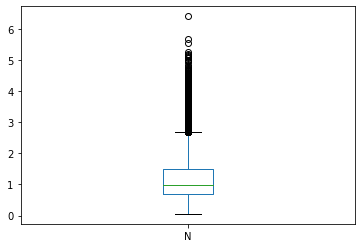

In [10]:
data_arc['N'].plot.box()

***Данные о подаче сыпучих материалов (время)***

In [11]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [12]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [13]:
print(data_bulk_time[data_bulk_time['Bulk 1'].isnull()].count())

key        2877
Bulk 1        0
Bulk 2        2
Bulk 3     1199
Bulk 4      901
Bulk 5       56
Bulk 6      530
Bulk 7        8
Bulk 8        1
Bulk 9       19
Bulk 10     168
Bulk 11     171
Bulk 12    2231
Bulk 13      16
Bulk 14    2575
Bulk 15    2068
dtype: int64


In [14]:
data_bulk_time = data_bulk_time.drop_duplicates().reset_index(drop=True)
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


***Данные о подаче сыпучих материалов (объем)***

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [17]:
data_bulk = data_bulk.drop_duplicates().reset_index(drop=True)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


***Данные о продувке сплава газом***

In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [20]:
print(data_gas[data_gas['Газ 1'].isnull()].count())

key      0
Газ 1    0
dtype: int64


In [21]:
data_gas = data_gas.drop_duplicates().reset_index(drop=True)
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


***Результаты измерения температуры***

In [22]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [23]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [24]:
data_temp = data_temp.drop_duplicates().reset_index(drop=True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [25]:
data_temp = data_temp.dropna()

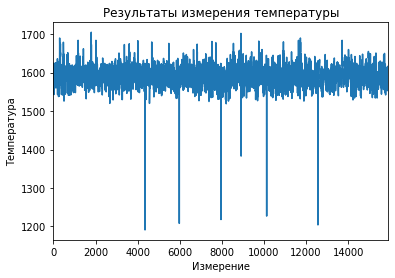

In [26]:
data_temp['Температура'].plot()
plt.title("Результаты измерения температуры")
plt.xlabel('Измерение')
plt.ylabel('Температура')
plt.show()

In [27]:
data_temp = data_temp.query('Температура >= 1500').reset_index(drop=True)

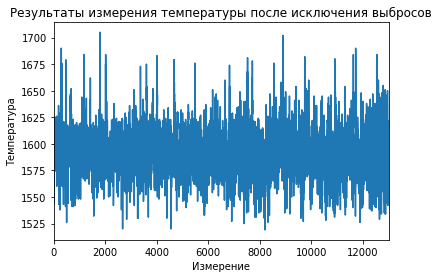

In [28]:
data_temp['Температура'].plot()
plt.title("Результаты измерения температуры после исключения выбросов")
plt.xlabel('Измерение')
plt.ylabel('Температура')
plt.show()

***Данные о проволочных материалах (время)***

In [29]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [30]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_wire_time = data_wire_time.drop_duplicates().reset_index(drop=True)
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


***Данные о проволочных материалах (объем)***

In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_wire = data_wire.drop_duplicates().reset_index(drop=True)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Объединяю все таблицы в одну**

Так как временные данные я не буду использовать в дальнейшем для построения модели, то таблицы data_bulk_time и data_wire_time мне не нужны.

In [35]:
d1 = data_arc.merge(data_bulk, on='key', how='left') 
d2 = d1.merge(data_gas, on='key', how='left')
d3 = d2.merge(data_temp, on='key', how='left') 
d4 = d3.merge(data_wire, on='key', how='left')

In [36]:
d4.columns.to_list()

['key',
 'Начало нагрева дугой',
 'Конец нагрева дугой',
 'Активная мощность',
 'Реактивная мощность',
 'N',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'Газ 1',
 'Время замера',
 'Температура',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9']

In [37]:
columns = ['key',
 'N',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'Газ 1',
 'Температура',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9']
df_new = pd.DataFrame(d4, columns=columns)

In [38]:
df_new

,key,N,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1571.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1604.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1618.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1601.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,1613.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63662,3241,0.888108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1586.0,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63663,3241,1.200235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1586.0,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63664,3241,1.209553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1586.0,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63665,3241,0.366462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1586.0,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_last_temp = df_new.groupby('key')['Температура'].last().to_frame()
df_first_temp = df_new.groupby('key')['Температура'].first().to_frame()

In [40]:
df_new = df_new.merge(df_last_temp, on='key', how='left', suffixes=('_temp', '_last_temp'))

In [41]:
df_new = df_first_temp.merge(df_new, on='key', how='left')

In [42]:
df_new

,key,Температура,N,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Температура_last_temp
0,1,1571.0,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0
1,1,1571.0,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0
2,1,1571.0,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0
3,1,1571.0,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0
4,1,1571.0,1.663142,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63662,3241,1586.0,0.888108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1586.0
63663,3241,1586.0,1.200235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1586.0
63664,3241,1586.0,1.209553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1586.0
63665,3241,1586.0,0.366462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1586.0


In [43]:
df_new = df_new.groupby('key').median()

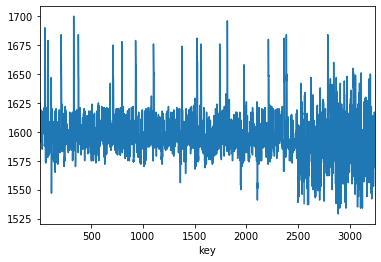

In [44]:
df_new['Температура_last_temp'].plot()

In [45]:
df_new = df_new.query('Температура_last_temp >= 1500').reset_index(drop=True)

In [46]:
df_new['diff_last_first'] = df_new['Температура_last_temp'] - df_new['Температура']

In [47]:
df_new['diff_last_first'].value_counts()

 0.0     781
 7.0      56
 3.0      52
 5.0      51
 21.0     48
        ... 
-58.0      1
 68.0      1
-88.0      1
-44.0      1
-67.0      1
Name: diff_last_first, Length: 138, dtype: int64

In [48]:
df_new = df_new.drop(df_new[df_new.diff_last_first == 0].index)

In [49]:
df_new

,Температура,N,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Температура_last_temp,diff_last_first
0,1571.0,1.325892,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0,42.0
1,1581.0,1.070137,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1602.0,21.0
2,1596.0,0.701129,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1599.0,3.0
3,1601.0,1.299850,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1625.0,24.0
4,1576.0,1.240463,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,...,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1602.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1570.0,1.499954,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.0,21.0
2471,1554.0,1.046358,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.0,37.0
2472,1571.0,1.442397,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1589.0,18.0
2473,1591.0,1.011218,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1594.0,3.0


In [50]:
df_new.columns.to_list()

['Температура',
 'N',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'Газ 1',
 'Температура_temp',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'Температура_last_temp',
 'diff_last_first']

In [51]:
numeric_columns = ['Температура',
 'N',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'Газ 1',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'Температура_last_temp']

Столбец Ware 5 удаляю совсем, так как в нем только нулевые значения.

In [52]:
df_new

,Температура,N,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Температура_last_temp,diff_last_first
0,1571.0,1.325892,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1613.0,42.0
1,1581.0,1.070137,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1602.0,21.0
2,1596.0,0.701129,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1599.0,3.0
3,1601.0,1.299850,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1625.0,24.0
4,1576.0,1.240463,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,...,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1602.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1570.0,1.499954,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.0,21.0
2471,1554.0,1.046358,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.0,37.0
2472,1571.0,1.442397,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1589.0,18.0
2473,1591.0,1.011218,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1594.0,3.0


In [53]:
df_new = df_new.fillna(0)

**Разобью данные на выборки:**

In [54]:
df_train, df_valid = train_test_split(df_new[numeric_columns], test_size=0.25, random_state=12345) 
features_train = df_train.drop(['Температура_last_temp'], axis=1)
target_train = df_train['Температура_last_temp']
features_valid = df_valid.drop(['Температура_last_temp'], axis=1)
target_valid = df_valid['Температура_last_temp'] 
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=12345) 
features_train = df_train.drop(['Температура_last_temp'], axis=1)
target_train = df_train['Температура_last_temp']
features_test = df_test.drop(['Температура_last_temp'], axis=1)
target_test = df_test['Температура_last_temp'] 

In [55]:
features_numeric_columns = ['Температура',
 'N',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'Газ 1',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9']
print(features_numeric_columns)

['Температура', 'N', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


**Масштабирую признаки:**

In [56]:
scaler=StandardScaler()
scaler.fit(features_train[features_numeric_columns])

features_train.loc[:, features_numeric_columns] = scaler.transform(features_train.loc[:, features_numeric_columns])
features_valid.loc[:, features_numeric_columns] = scaler.transform(features_valid.loc[:, features_numeric_columns])
features_test.loc[:, features_numeric_columns] = scaler.transform(features_test.loc[:, features_numeric_columns])

## Обучение моделей

**Модель "Линейная регрессия"**

In [57]:
%%time
LR_model = LinearRegression()
LR_model.fit(features_train, target_train)
predictions_valid = LR_model.predict(features_valid)
LR_result = mean_absolute_error(target_valid, predictions_valid)
print('MAE модели линейной регрессии на валидационной выборке:', LR_result)

MAE модели линейной регрессии на валидационной выборке: 9.030648423145413
CPU times: user 40.6 ms, sys: 54.6 ms, total: 95.1 ms
Wall time: 85.7 ms


**Модель "Дерево решений"**

In [58]:
%%time
DR_model = DecisionTreeRegressor(random_state=12345)
DR_parameters = {'max_depth': range(1,10)}
DR_grid = GridSearchCV(DR_model, DR_parameters, cv=3)
DR_grid.fit(features_train, target_train)
DR_best_parameters = DR_grid.best_params_
print('Оптимальные параметры модели:', DR_best_parameters)

Оптимальные параметры модели: {'max_depth': 4}
CPU times: user 195 ms, sys: 37.9 ms, total: 233 ms
Wall time: 247 ms


In [59]:
%%time
DR_model = DecisionTreeRegressor(random_state=12345, max_depth=4) 
DR_model.fit(features_train, target_train)
DR_predictions_valid= DR_model.predict(features_valid) 
DR_result = mean_absolute_error(target_valid, DR_predictions_valid) 
print("MAE модели дерево решений на валидационной выборке:", DR_result)

MAE модели дерево решений на валидационной выборке: 8.094157656122485
CPU times: user 6.99 ms, sys: 280 µs, total: 7.27 ms
Wall time: 6.06 ms


**Модель "Случайный лес"**

In [60]:
%%time
SL_model = RandomForestRegressor(random_state=12345)
SL_parameters = {'n_estimators': range(10,100, 10), 'max_depth': range(1,10)}
SL_grid = GridSearchCV(SL_model, SL_parameters, cv=3)
SL_grid.fit(features_train, target_train)
SL_best_parameters = SL_grid.best_params_
print('Оптимальные параметры модели:', SL_best_parameters)

Оптимальные параметры модели: {'max_depth': 9, 'n_estimators': 80}
CPU times: user 31.2 s, sys: 155 ms, total: 31.4 s
Wall time: 31.5 s


In [61]:
%%time
SL_model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=80) 
SL_model.fit(features_train, target_train) 
SL_predictions_valid = SL_model.predict(features_valid) 
SL_result = mean_absolute_error(target_valid, SL_predictions_valid)  
print("MAE модели случайный лес на валидационной выборке:", SL_result)

MAE модели случайный лес на валидационной выборке: 7.3169718807486825
CPU times: user 418 ms, sys: 3.85 ms, total: 422 ms
Wall time: 431 ms


**Сводная таблица значений МАЕ для трех моделей**

In [62]:
duration_pr = {'Параметр': ['MAE'],
       'Модель "Линейная регрессия"': [LR_result], 
       'Модель "Дерево решений"': [DR_result],
       'Модель "Случайный лес"': [SL_result],       
      }

duration_percent = pd.DataFrame(duration_pr, columns = ['Параметр', 'Модель "Линейная регрессия"', 
                                                        'Модель "Дерево решений"', 'Модель "Случайный лес"'])
duration_percent

,Параметр,"Модель ""Линейная регрессия""","Модель ""Дерево решений""","Модель ""Случайный лес"""
0,MAE,9.030648,8.094158,7.316972


**Перед тестированием лучшей модели ("Случайный лес") объединяю обучающую выборку и валидационную**

In [63]:
test_features_train = pd.concat([features_train, features_valid])
test_target_train = pd.concat([target_train, target_valid])

In [64]:
SL_model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=80) 
SL_model.fit(test_features_train, test_target_train) 
SL_predictions_test= SL_model.predict(features_test) 
SL_result_test = mean_absolute_error(target_test, SL_predictions_test)
print("MAE модели дерево решений на валидационной выборке:", SL_result_test)

MAE модели дерево решений на валидационной выборке: 6.798814394174425


**Вывод:**

В данном проекте решалась задача оптимизации производственных расходов. Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. <br>
Была проведена предобработка данных и построена модель, которая предскажет температуру стали. <br>

Все пункты плана работ были выполнены:
    1. Определиться с признаками (вопрос с температурами).
    2. Построить модели
    3. Добиться нужного значения метрики МАЕ
    4. Сделать выводы
    5. Написать отчет

Лучшее значение метрики MAE показала модель "Случайный лес". МАЕ на тестовой выборке = 6.79.